In [1]:
import numpy as np
import os
import math
import torch
import torch.nn as nn
import torchnet as tnt
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision import models
from torchvision.datasets.mnist import MNIST, FashionMNIST
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.models as models
import torchvision.utils as vutils

import matplotlib.pyplot as plt
from IPython import display
from tqdm import tqdm_notebook as tqdm
from torchsummary import summary

from PIL import Image
import matplotlib.cm as mpl_color_map
from utls import *


print(torch.__version__)
device = torch.device('cuda:0')
torch.set_default_tensor_type('torch.cuda.FloatTensor')

1.2.0


https://medium.com/ai-society/gans-from-scratch-1-a-deep-introduction-with-code-in-pytorch-and-tensorflow-cb03cdcdba0f

In [2]:
BATCH_SIZE = 128
image_size = 64
normalize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])
    ])

data_path = os.path.dirname(os.getcwd()) + "/data/weed/"
Train_data = Weedread(data_path + "train.h5", transform=normalize, cl=[0])
Test_data = Weedread(data_path + "val.h5", transform=normalize)

Train_dataloader = DataLoader(dataset=Train_data, batch_size = BATCH_SIZE, shuffle=True)
Test_dataloader = DataLoader(dataset=Test_data, batch_size = BATCH_SIZE, shuffle=False)

print(Train_data.__len__())
manualSeed = 999
torch.manual_seed(manualSeed)

104154


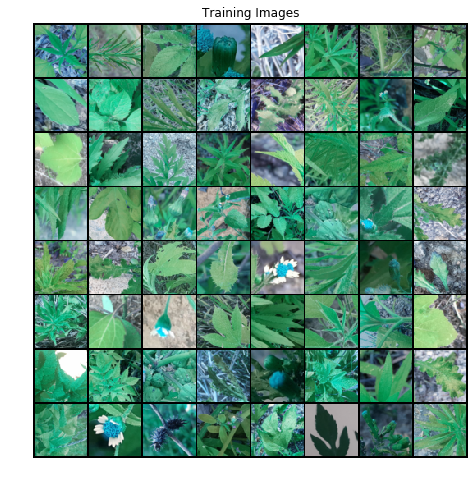

In [3]:
real_batch = next(iter(Train_dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [4]:
nc = 3  #Number of channels in the training images
nz = 100 #Size of z latent vector
ngf = 64 #Size of feature maps in generator
ndf = 64 #Size of feature maps in discriminator

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class GeneratorNet(nn.Module):
    def __init__(self):
        super(GeneratorNet, self).__init__() 
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )
        self.apply(weights_init)

    def forward(self, input):
        return self.main(input)
    
class DiscriminatorNet(nn.Module):
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 5, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 5, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 5, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 5, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 3, 1, 0, bias=False),
            nn.Sigmoid()
        )
        self.apply(weights_init)

    def forward(self, input):
        x = self.main(input)
        return x.view(-1, 1)

In [5]:
class Trainer():
    def __init__(self, generator, discriminator):
        
        self.N = 1 #batch_size
        self.discriminator = discriminator
        self.generator = generator
        self.loss = nn.BCELoss()
        self.d_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        self.g_optimizer = torch.optim.Adam(self.generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    
    def noise(self, size):
        '''
        Generates a 1-d vector of gaussian sampled random values
        '''
        n = Variable(torch.randn(size, 100, 1, 1))
        return n
        
    def train_discriminator(self, real_data):
        self.N = real_data.size(0)
        self.d_optimizer.zero_grad()
        smothness = 0.05
        # 1.1 Train on Real Data
        prediction_real = self.discriminator(real_data)
        # Calculate error and backpropagate
        error_real = self.loss(prediction_real, Variable(torch.ones(self.N, 1) - smothness))
        error_real.backward()
        # 1.2 Train on Fake Data
        # Generate fake data and detach 
        # (so gradients are not calculated for generator)
        fake_data = self.generator(self.noise(self.N)).detach()
        prediction_fake = self.discriminator(fake_data)
        # Calculate error and backpropagate
        error_fake = self.loss(prediction_fake, Variable(torch.zeros(self.N, 1) + smothness))
        error_fake.backward()
        # 1.3 Update weights with gradients
        self.d_optimizer.step()

        return error_real + error_fake, prediction_real, prediction_fake

    def train_generator(self):
        
        self.g_optimizer.zero_grad()
        fake_data = self.generator(self.noise(self.N))
        # Sample noise and generate fake data
        prediction = self.discriminator(fake_data)
        # Calculate error and backpropagate
        error = self.loss(prediction, Variable(torch.ones(self.N, 1)))
        error.backward()
        # Update weights with gradients
        self.g_optimizer.step()
        # Return error
        return error

In [6]:
_discriminator = DiscriminatorNet().to(device)
_generator = GeneratorNet().to(device)

train_images, _, _ = next(iter(Test_dataloader))
summary(_discriminator, input_size= train_images[0].size())
summary(_generator, input_size= (100, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 31, 31]           4,800
         LeakyReLU-2           [-1, 64, 31, 31]               0
            Conv2d-3          [-1, 128, 15, 15]         204,800
       BatchNorm2d-4          [-1, 128, 15, 15]             256
         LeakyReLU-5          [-1, 128, 15, 15]               0
            Conv2d-6            [-1, 256, 7, 7]         819,200
       BatchNorm2d-7            [-1, 256, 7, 7]             512
         LeakyReLU-8            [-1, 256, 7, 7]               0
            Conv2d-9            [-1, 512, 3, 3]       3,276,800
      BatchNorm2d-10            [-1, 512, 3, 3]           1,024
        LeakyReLU-11            [-1, 512, 3, 3]               0
           Conv2d-12              [-1, 1, 1, 1]           4,608
          Sigmoid-13              [-1, 1, 1, 1]               0
Total params: 4,312,000
Trainable param

In [ ]:
logger = GAN_Logger(_generator, _discriminator, file_name="GAN", num_classes=10)
trainer = Trainer(_generator, _discriminator)
    
fix_noises = Variable(torch.randn(64, 100, 1, 1))
# Total number of epochs to train

num_epochs = 200
for epoch in range(1, num_epochs + 1):
    print("[%d/%d]"%(epoch, num_epochs))
    for real_batch,_,_ in tqdm(Train_dataloader):
        real_batch = real_batch.to(device)
        # 1. Train Discriminator
        real_data = Variable(real_batch)
        
        # Train D
        d_error, d_pred_real, d_pred_fake = trainer.train_discriminator(real_data)

        # 2. Train Generator
        for i in range(3):
            g_error = trainer.train_generator()
        
        logger.batch_update(gen_loss = g_error, dis_loss = d_error)
        
    with torch.no_grad():
        fake_data = _generator(fix_noises).detach()
        fake_img = fake_data.cpu().data
        logger.epoch_update(epoch=epoch, recons=fake_img)
    
     

Setting up a new session...
Setting up a new session...


[1/200]
